In [4]:
import sys
import scipy.io
import numpy as np
sys.path.append('../src')
import pandas as pd
import matplotlib.pyplot as plt
from mvt_brr import MVTModel
import scipy.optimize as opt
from scipy.stats import pearsonr
from world import Patch, Agent
from simulation import Simulation


In [62]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

In [2]:
data = scipy.io.loadmat('../leheron_trialbytrial/leheron_blockSwitchIndex.mat')
block_order_df = pd.read_csv('../leheron_trialbytrial/leheron_blockOrder.csv')
df_trials = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")

In [3]:
grouped_df = df_trials.groupby(['env', 'patch']).agg(
    mean_leaveT=('leaveT','mean'),
    sd_leaveT=('leaveT', 'std')
).reset_index()

print(grouped_df)

   env  patch  mean_leaveT  sd_leaveT
0    1      1    11.137706   6.020383
1    1      2    15.051354   6.435201
2    1      3    19.709716   7.450578
3    2      1    14.309812   6.639575
4    2      2    18.947625   7.008822
5    2      3    23.441306   7.471792


In [5]:
class Agent:
    def __init__(self, beta=1.0, intercept=0, omega=0.5):
        self.beta = beta
        self.intercept = intercept
        self.omega = omega

    # Softmax policy
    def leave_proba_softmax(self, reward):
        """ Compute the probability of leaving given the reward using softmax. """
        return 1 / (1 + np.exp(self.intercept + self.beta * reward))

    def choose_action_softmax(self, reward):
        leave_proba = self.leave_proba_softmax(reward)
        # Check if leave_proba is a list of one element
        if isinstance(leave_proba, np.ndarray) and len(leave_proba) == 1:
            leave_proba = leave_proba[0]
        return np.random.choice([0, 1], p=[1-leave_proba, leave_proba])  # 0: stay, 1: leave

In [15]:
# Function to normalize data using StandardScaler
def normalize_with_scaler(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    return normalized_data, scaler

def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    return normalized_data, mean, std

In [131]:
# Recalculate model leaving times with optimized parameters
def calculate_model_leaveT(row, results_df, beta_col_name, intercept_col_name):
    participant_result = results_df[(results_df['participant'] == row['sub']) & (results_df['environment'] == row['env'])]
    beta = participant_result['beta_combined'].values[0]
    intercept = participant_result['intercept_combined'].values[0]
    agent = Agent(beta=beta, intercept=intercept)
    sim = Simulation(decay_rate=0.075, model='softmax')
    env = sim.patch_types[int(row['patch'])-1]
    leave_times = sim.simulate(env, agent, n_runs=30)
    return np.mean(leave_times)

In [134]:
def LeHeron_simulation_beta_vary(beta, patch_types, observed_leave, intercept):
    agent = Agent(beta=beta, intercept=intercept)
    sim = Simulation(decay_rate=0.075, model='softmax')

    # Organize leave times by patch type
    patch_type_leave_times = {patch_type: [] for patch_type in set(patch_types)}
    patch_type_observed_leave = {patch_type: [] for patch_type in set(patch_types)}

    for i, patch_type in enumerate(patch_types):
        patch_id = sim.patch_types[patch_type-1]
        leave_times = sim.simulate(patch_id, agent, n_runs=10)
        patch_type_leave_times[patch_type].extend([np.mean(leave_times)])
        patch_type_observed_leave[patch_type].append(observed_leave[i])

    rmse = error_calculation(patch_type_leave_times, patch_type_observed_leave)
    return rmse

In [63]:
def combined_error(beta, patch_types, observed_leave, intercept):
    # beta, intercept = params
    agent = Agent(beta=beta, intercept=intercept)
    sim = Simulation(decay_rate=0.075, model='softmax')
    
    simulated_leave_times = []
    for patch_type in patch_types:
        patch_id = sim.patch_types[patch_type-1]
        leave_times = sim.simulate(patch_id, agent, n_runs=3)
        simulated_leave_times.extend([np.mean(leave_times)])

    # print(len(simulated_leave_times))
    # mean_simulated_leave = np.mean(simulated_leave_times)
    # mean_observed_leave = np.mean(observed_leave)
    # error = np.abs(mean_simulated_leave - mean_observed_leave)

    # # Convert to numpy arrays
    # observed_leave = np.array(observed_leave)
    # simulated_leave_times = np.array(simulated_leave_times)

    # # Normalize the leave times using the normalization function
    # normalized_observed_leave, observed_mean, observed_std = normalize(observed_leave)
    # normalized_simulated_leave, simulated_mean, simulated_std = normalize(simulated_leave_times)

    # # Normalize the leave times using StandardScaler
    # normalized_observed_leave, observed_scaler = normalize_with_scaler(observed_leave)
    # normalized_simulated_leave = observed_scaler.transform(simulated_leave_times.reshape(-1, 1)).flatten()

    # rmse = np.sqrt(np.mean((np.array(simulated_leave_times) - np.array(observed_leave)) ** 2))
    # rmse = np.sqrt(np.mean((normalized_simulated_leave - normalized_observed_leave) ** 2))
    # mae = np.mean(np.abs(normalized_simulated_leave - normalized_observed_leave))
    # var_error = np.abs(np.var(simulated_leave_times) - np.var(observed_leave))
    # combined_error = np.abs(mean_simulated_leave - mean_observed_leave) + var_error
    ks_stat, ks_p_value = ks_2samp(simulated_leave_times, observed_leave)
    return ks_stat


In [132]:
def error_calculation(patch_type_leave_times, patch_type_observed_leave):
    # Calculate mean leave times for each patch type
    mean_simulated_leave = {patch_type: np.mean(times) for patch_type, times in patch_type_leave_times.items()}
    mean_observed_leave = {patch_type: np.mean(times) for patch_type, times in patch_type_observed_leave.items()}

    # Calculate squared errors based on the mean of each patch type
    squared_errors = [(mean_simulated_leave[patch_type] - mean_observed_leave[patch_type]) ** 2 for patch_type in patch_type_leave_times]
    rmse_error = np.sqrt(np.sum(squared_errors))

    return rmse_error

In [135]:
# Fit model for each environment
environments = df_trials['env'].unique()
results = []

# Define the constant intercept
constant_intercept = -3

for env in environments:
    env_data = df_trials[df_trials['env'] == env]
    participants = env_data['sub'].unique()
    
    for participant in participants:
        participant_data = env_data[env_data['sub'] == participant]
        patches = participant_data['patch'].values
        leave_times = participant_data['leaveT'].values

        # Initial guess for beta
        initial_beta = 0.3

        # Optimize for RMSE using the correct simulation with a constant intercept
        res_combined = opt.minimize(LeHeron_simulation_beta_vary, initial_beta, method='nelder-mead', args=(patches, leave_times, constant_intercept), options={'xatol': 1e-6, 'disp': True})

        # options = {
        #     'disp': True,
        #     'gtol': 1e-6,
        #     'maxiter':1000
        # }
        # res_bfgs = opt.minimize(error_calculation, initial_beta, method='BFGS', args=(patches, leave_times, constant_intercept), options=options)
        # bounds = [(0,1)]
        # res_de = opt.differential_evolution(error_calculation, bounds, args=(patches, leave_times, constant_intercept))
        
        results.append({
            'environment': env,
            'participant': participant,
            'beta_combined': res_combined.x[0],
            'intercept_combined': constant_intercept,
            'rmse': res_combined.fun
        })

results_df = pd.DataFrame(results)
print(results_df)

/var/folders/fp/j9ldfbxj2_gflf_hz4bf_wyc0000gn/T/ipykernel_20433/3083919976.py:21: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res_combined = opt.minimize(LeHeron_simulation_beta_vary, initial_beta, method='nelder-mead', args=(patches, leave_times, constant_intercept), options={'xatol': 1e-6, 'disp': True})


    environment  participant  beta_combined  intercept_combined      rmse
0             1            1       2.204883                  -3  9.859164
1             1            2       0.190840                  -3  0.170460
2             1            3       0.295430                  -3  1.348908
3             1            4       0.230625                  -3  0.444341
4             1            5       0.149062                  -3  1.985159
..          ...          ...            ...                 ...       ...
73            2           35       0.378752                  -3  0.782728
74            2           36       0.439219                  -3  1.992720
75            2           37       0.434941                  -3  3.072273
76            2           38       0.359063                  -3  3.144542
77            2           39       0.517471                  -3  3.641772

[78 rows x 5 columns]


In [136]:
df_trials['model_leaveT'] = df_trials.apply(calculate_model_leaveT, axis=1, results_df=results_df)
mean_times = df_trials.groupby(['sub', 'env']).agg(mean_leaveT=('leaveT', 'mean'), mean_model_leaveT=('model_leaveT', 'mean')).reset_index()
mean_times

,sub,env,mean_leaveT,mean_model_leaveT
0,1,1,47.294338,43.400000
1,1,2,34.997398,36.044444
2,2,1,11.283426,11.036190
3,2,2,10.824704,10.230476
4,3,1,16.733743,17.177778
...,...,...,...,...
73,37,2,19.174653,19.715278
74,38,1,16.645795,15.953086
75,38,2,16.648229,17.124359
76,39,1,19.894120,19.126087


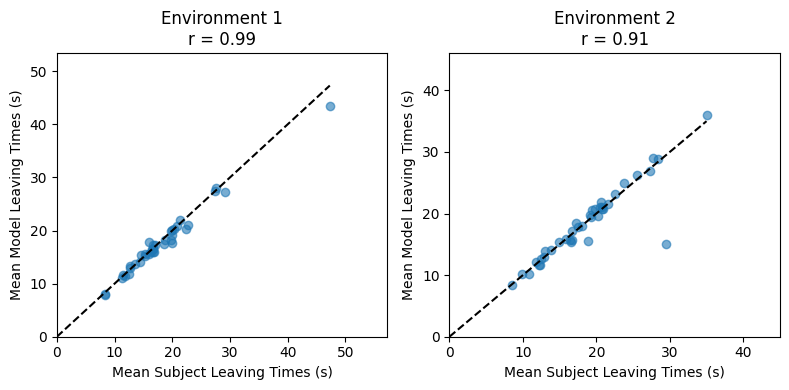

In [137]:
# Plot comparison
plt.figure(figsize=(8, 4))

for i, env in enumerate(environments, 1):
    env_data = mean_times[mean_times['env'] == env]
    
    plt.subplot(1, len(environments), i)
    plt.scatter(env_data['mean_leaveT'], env_data['mean_model_leaveT'], alpha=0.6)
    plt.plot([0, env_data['mean_leaveT'].max()], [0, env_data['mean_leaveT'].max()], 'k--')
    
    # Calculate correlation coefficient
    r, _ = pearsonr(env_data['mean_leaveT'], env_data['mean_model_leaveT'])
    
    plt.xlabel('Mean Subject Leaving Times (s)')
    plt.ylabel('Mean Model Leaving Times (s)')
    plt.title(f'Environment {env}\nr = {r:.2f}')
    plt.xlim(0, env_data['mean_leaveT'].max() + 10)
    plt.ylim(0, env_data['mean_model_leaveT'].max() + 10)

plt.tight_layout()
plt.show()

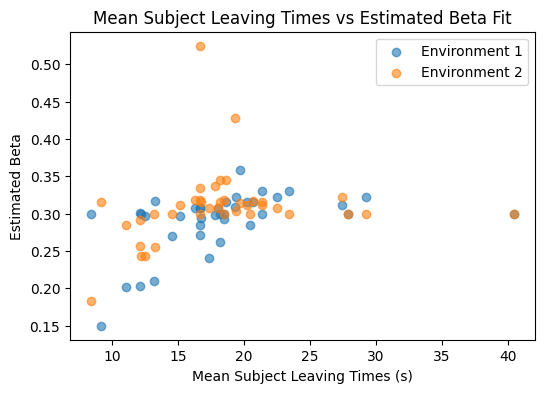

In [67]:
# Calculate mean leaving times per participant
mean_leaving_times = df_trials.groupby('sub')['leaveT'].mean().reset_index()
mean_leaving_times.columns = ['participant', 'mean_leaveT']

# Merge with the results_df to get the beta values
merged_df = pd.merge(results_df, mean_leaving_times, left_on='participant', right_on='participant')

# Plot the mean leaving times vs estimated beta fit
plt.figure(figsize=(6, 4))

for env in merged_df['environment'].unique():
    env_data = merged_df[merged_df['environment'] == env]
    plt.scatter(env_data['mean_leaveT'], env_data['beta_combined'], label=f'Environment {env}', alpha=0.6)

plt.xlabel('Mean Subject Leaving Times (s)')
plt.ylabel('Estimated Beta')
plt.title('Mean Subject Leaving Times vs Estimated Beta Fit')
plt.legend()
plt.show()

### Beta and intercept vary

In [75]:
def combined_error(params, patch_types, observed_leave):
    beta, intercept = params
    agent = Agent(beta=beta, intercept=intercept)
    sim = Simulation(decay_rate=0.075, model='softmax')
    
    simulated_leave_times = []
    for patch_type in patch_types:
        patch_id = sim.patch_types[patch_type-1]
        leave_times = sim.simulate(patch_id, agent, n_runs=1)
        simulated_leave_times.extend([np.mean(leave_times)])

    # print(len(simulated_leave_times))
    mean_simulated_leave = np.mean(simulated_leave_times)
    mean_observed_leave = np.mean(observed_leave)
    error = np.abs(mean_simulated_leave - mean_observed_leave)

    # # Convert to numpy arrays
    # observed_leave = np.array(observed_leave)
    # simulated_leave_times = np.array(simulated_leave_times)

    # # Normalize the leave times using the normalization function
    # normalized_observed_leave, observed_mean, observed_std = normalize(observed_leave)
    # normalized_simulated_leave, simulated_mean, simulated_std = normalize(simulated_leave_times)

    # # Normalize the leave times using StandardScaler
    # normalized_observed_leave, observed_scaler = normalize_with_scaler(observed_leave)
    # normalized_simulated_leave = observed_scaler.transform(simulated_leave_times.reshape(-1, 1)).flatten()

    # rmse = np.sqrt(np.mean((np.array(simulated_leave_times) - np.array(observed_leave)) ** 2))
    # rmse = np.sqrt(np.mean((normalized_simulated_leave - normalized_observed_leave) ** 2))
    # mae = np.mean(np.abs(normalized_simulated_leave - normalized_observed_leave))
    # var_error = np.abs(np.var(simulated_leave_times) - np.var(observed_leave))
    # combined_error = np.abs(mean_simulated_leave - mean_observed_leave) + var_error
    # ks_stat, ks_p_value = ks_2samp(simulated_leave_times, observed_leave)
    return error

In [100]:
def LeHeron_simulation_params_vary(params, patch_types, observed_leave):
    beta, intercept = params
    agent = Agent(beta=beta, intercept=intercept)
    sim = Simulation(decay_rate=0.075, model='softmax')

    # Organize leave times by patch type
    patch_type_leave_times = {patch_type: [] for patch_type in set(patch_types)}
    patch_type_observed_leave = {patch_type: [] for patch_type in set(patch_types)}

    for i, patch_type in enumerate(patch_types):
        patch_id = sim.patch_types[patch_type-1]
        leave_times = sim.simulate(patch_id, agent, n_runs=3)
        patch_type_leave_times[patch_type].extend([np.mean(leave_times)])
        patch_type_observed_leave[patch_type].append(observed_leave[i])

    return patch_type_leave_times, patch_type_observed_leave

In [101]:
def error_calculation(params, patch_types, observed_leave):
    patch_type_leave_times, patch_type_observed_leave = LeHeron_simulation_params_vary(params, patch_types, observed_leave)

    # print(patch_type_leave_times, patch_type_observed_leave)
    # Calculate mean leave times for each patch type
    mean_simulated_leave = {patch_type: np.mean(times) for patch_type, times in patch_type_leave_times.items()}
    mean_observed_leave = {patch_type: np.mean(times) for patch_type, times in patch_type_observed_leave.items()}

    # Calculate squared errors based on the mean of each patch type
    squared_errors = [(mean_simulated_leave[patch_type] - mean_observed_leave[patch_type]) ** 2 for patch_type in patch_type_leave_times]
    rmse_error = np.sqrt(np.sum(squared_errors))

    return rmse_error

In [91]:
# env_data = df_trials[df_trials['env'] == 1]

# participant_data = env_data[env_data['sub'] == 2]
# patches = participant_data['patch'].values
# leave_times = participant_data['leaveT'].values

# combined_error([0.3, -3], patches, leave_times)

{np.int64(1): [np.float64(13.333333333333334), np.float64(12.0), np.float64(13.0), np.float64(11.0), np.float64(15.333333333333334), np.float64(11.0), np.float64(15.333333333333334)], np.int64(2): [np.float64(18.333333333333332), np.float64(19.666666666666668), np.float64(17.666666666666668), np.float64(16.0), np.float64(17.333333333333332), np.float64(17.0), np.float64(16.0), np.float64(17.666666666666668), np.float64(16.666666666666668), np.float64(16.0), np.float64(18.333333333333332)], np.int64(3): [np.float64(23.666666666666668), np.float64(20.666666666666668), np.float64(18.666666666666668), np.float64(20.333333333333332), np.float64(17.666666666666668), np.float64(24.333333333333332), np.float64(19.0), np.float64(18.333333333333332), np.float64(18.333333333333332), np.float64(22.333333333333332), np.float64(18.333333333333332), np.float64(18.0), np.float64(15.666666666666666), np.float64(16.333333333333332), np.float64(20.0), np.float64(20.666666666666668), np.float64(21.3333333

np.float64(11.203751241816004)

In [106]:
# Fit model for each environment
environments = df_trials['env'].unique()
results = []

for env in environments:
    env_data = df_trials[df_trials['env'] == env]
    participants = env_data['sub'].unique()
    
    for participant in participants:
        participant_data = env_data[env_data['sub'] == participant]
        patches = participant_data['patch'].values
        leave_times = participant_data['leaveT'].values

        # Initial guess 
        initial_params = [0.3, -3]

        # Optimize for RMSE using the correct simulation with a constant intercept
        res_combined = opt.minimize(error_calculation, initial_params, method='nelder-mead', args=(patches, leave_times), options={'xatol': 1e-8, 'disp': True})
        # res_bfgs = opt.minimize(error_calculation, initial_params, method='BFGS', args=(patches, leave_times), options={'disp': True})

        results.append({
            'environment': env,
            'participant': participant,
            'beta_combined': res_combined.x[0],
            'intercept_combined': res_combined.x[1],
            'rmse': res_combined.fun
        })

results_df = pd.DataFrame(results)
print(results_df)

/var/folders/fp/j9ldfbxj2_gflf_hz4bf_wyc0000gn/T/ipykernel_20433/4121282957.py:18: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res_combined = opt.minimize(error_calculation, initial_params, method='nelder-mead', args=(patches, leave_times), options={'xatol': 1e-8, 'disp': True})


    environment  participant  beta_combined  intercept_combined      rmse
0             1            1       0.651221            1.058296  4.631182
1             1            2       0.217373           -3.753071  0.216724
2             1            3       0.285931           -3.121867  0.591399
3             1            4       0.254693           -3.589313  0.348345
4             1            5       0.186853           -4.020234  1.419524
..          ...          ...            ...                 ...       ...
73            2           35       0.340400           -2.477051  0.510532
74            2           36       0.303750           -3.018750  7.578379
75            2           37       0.381306           -2.415527  1.958214
76            2           38       0.336763           -2.452735  2.557958
77            2           39       0.356484           -1.706250  2.039920

[78 rows x 5 columns]


In [107]:
df_trials['model_leaveT'] = df_trials.apply(calculate_model_leaveT, axis=1, results_df=results_df)
mean_times = df_trials.groupby(['sub', 'env']).agg(mean_leaveT=('leaveT', 'mean'), mean_model_leaveT=('model_leaveT', 'mean')).reset_index()
mean_times

,sub,env,mean_leaveT,mean_model_leaveT
0,1,1,47.294338,43.883333
1,1,2,34.997398,33.842222
2,2,1,11.283426,10.876190
3,2,2,10.824704,10.784762
4,3,1,16.733743,16.258025
...,...,...,...,...
73,37,2,19.174653,19.686111
74,38,1,16.645795,15.434568
75,38,2,16.648229,17.852564
76,39,1,19.894120,19.557971


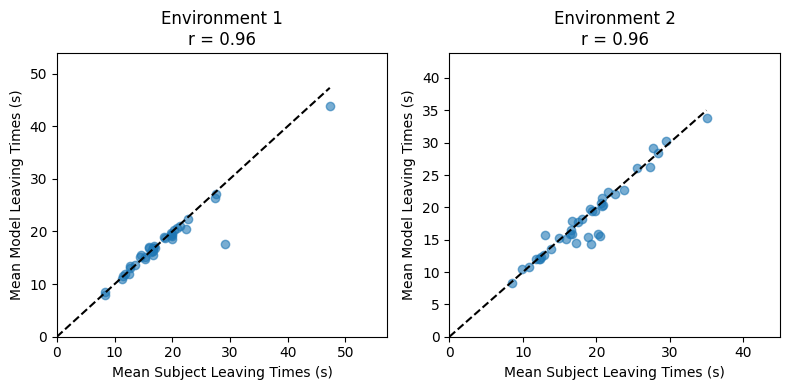

In [108]:
# Plot comparison
plt.figure(figsize=(8, 4))

for i, env in enumerate(environments, 1):
    env_data = mean_times[mean_times['env'] == env]
    
    plt.subplot(1, len(environments), i)
    plt.scatter(env_data['mean_leaveT'], env_data['mean_model_leaveT'], alpha=0.6)
    plt.plot([0, env_data['mean_leaveT'].max()], [0, env_data['mean_leaveT'].max()], 'k--')
    
    # Calculate correlation coefficient
    r, _ = pearsonr(env_data['mean_leaveT'], env_data['mean_model_leaveT'])
    
    plt.xlabel('Mean Subject Leaving Times (s)')
    plt.ylabel('Mean Model Leaving Times (s)')
    plt.title(f'Environment {env}\nr = {r:.2f}')
    plt.xlim(0, env_data['mean_leaveT'].max() + 10)
    plt.ylim(0, env_data['mean_model_leaveT'].max() + 10)

plt.tight_layout()
plt.show()

### script results

In [261]:
# Recalculate model leaving times with optimized parameters
def calculate_model_leaveT(row, results_df, beta_col_name, intercept_col_name):
    participant_result = results_df[(results_df['participant'] == row['sub']) & (results_df['environment'] == row['env'])]
    beta = participant_result[beta_col_name].values[0]
    intercept = participant_result[intercept_col_name].values[0]
    agent = Agent(beta=beta, intercept=intercept)
    sim = Simulation(decay_rate=0.075, model='softmax')
    env = sim.patch_types[int(row['patch'])-1]
    leave_times = sim.simulate(env, agent, n_runs=3)
    return np.mean(leave_times)

In [235]:
results_df = pd.read_csv('../src/optimization_results.csv')
results_df.head()

,environment,participant,beta_vary,intercept_constant,rmse_beta,beta_both_vary,intercept_both_vary,rmse_both,beta_constant,intercept_vary,rmse_intercept
0,1,1,2.070000,-3,9.324893,0.336610,-2.202100,41.097683,0.3,-2.946094,47.738871
1,1,2,0.192187,-3,0.030925,0.277500,-2.925000,6.904302,0.3,-5.850000,0.131968
2,1,3,0.285008,-3,0.416360,0.285000,-3.000000,0.442423,0.3,-3.150000,1.042074
3,1,4,0.300000,-3,4.904756,0.231094,-3.117188,0.197278,0.3,-4.298429,0.466866
4,1,5,0.153735,-3,1.221660,0.183047,-4.112695,1.777209,0.3,-3.150069,12.628180


In [262]:
df_trials['pred_both_model'] = df_trials.apply(calculate_model_leaveT, axis=1, results_df=results_df, beta_col_name = 'beta_both_vary', intercept_col_name = 'intercept_both_vary')
df_trials['pred_beta_model'] = df_trials.apply(calculate_model_leaveT, axis=1, results_df=results_df, beta_col_name = 'beta_vary', intercept_col_name = 'intercept_constant')
df_trials['pred_intercept_model'] = df_trials.apply(calculate_model_leaveT, axis=1, results_df=results_df, beta_col_name = 'beta_constant', intercept_col_name = 'intercept_vary')
mean_times = df_trials.groupby(['sub', 'env']).agg(
    mean_leaveT=('leaveT', 'mean'),
    mean_model_leaveT_both=('pred_both_model', 'mean'),
    mean_model_leaveT_beta=('pred_beta_model', 'mean'),
    mean_model_leaveT_intercept=('pred_intercept_model', 'mean')
).reset_index()
mean_times

,sub,env,mean_leaveT,mean_model_leaveT_both,mean_model_leaveT_beta,mean_model_leaveT_intercept
0,1,1,47.294338,21.055556,43.916667,16.666667
1,1,2,34.997398,34.244444,17.222222,15.511111
2,2,1,11.283426,15.895238,11.019048,11.180952
3,2,2,10.824704,10.019048,9.914286,14.457143
4,3,1,16.733743,16.987654,16.419753,17.259259
...,...,...,...,...,...,...
73,37,2,19.174653,20.416667,21.083333,14.847222
74,38,1,16.645795,15.901235,17.024691,17.407407
75,38,2,16.648229,15.602564,15.897436,14.512821
76,39,1,19.894120,19.260870,19.347826,19.405797


In [226]:
def plot_model_fit_comparisons_to_subject_leaving_times(mean_times, sub_col_name, model_col_name):
    title = sub_col_name.split('_')[0]
    # Map environment numbers to labels
    env_labels = {1: 'Rich', 2: 'Poor'}
    env_colors = {1: 'blue', 2: 'green'}
    environments = [1, 2]

    # Plot comparison
    plt.figure(figsize=(6, 3))

    for i, env in enumerate(environments, 1):
        env_data = mean_times[mean_times['env'] == env]
        
        plt.subplot(1, len(environments), i)
        plt.scatter(env_data[sub_col_name], env_data[model_col_name], alpha=0.6, color=env_colors[env])
        plt.plot([0, env_data[sub_col_name].max()], [0, env_data[sub_col_name].max()], 'k--')
        
        # Calculate correlation coefficient
        r, _ = pearsonr(env_data[sub_col_name], env_data[model_col_name])
        
        plt.xlabel(f'{title} Subject Leaving Times (s)')
        plt.ylabel(f'{title} Model Leaving Times (s)')
        plt.title(f'{env_labels[env]} Environment\nr = {r:.2f}')
        plt.xlim(0, env_data[sub_col_name].max() + 10)
        plt.ylim(0, env_data[model_col_name].max() + 10)

    plt.tight_layout()
    plt.show()

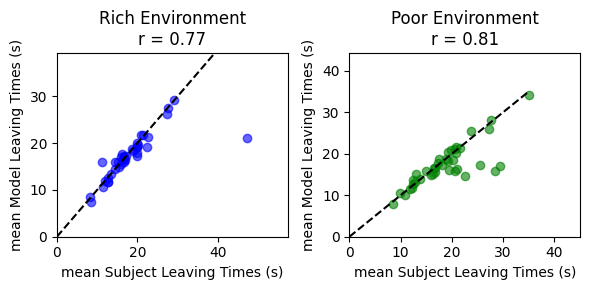

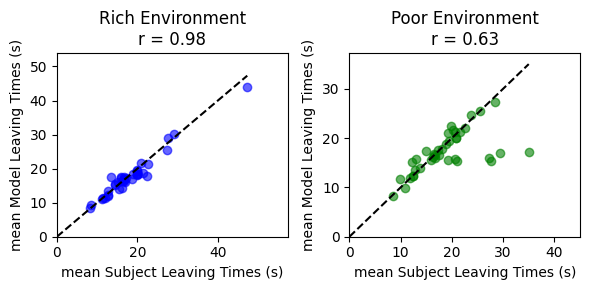

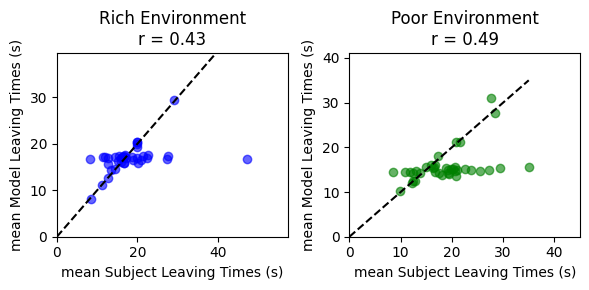

In [263]:
plot_model_fit_comparisons_to_subject_leaving_times(mean_times, "mean_leaveT", "mean_model_leaveT_both")
plot_model_fit_comparisons_to_subject_leaving_times(mean_times, "mean_leaveT", "mean_model_leaveT_beta")
plot_model_fit_comparisons_to_subject_leaving_times(mean_times, "mean_leaveT", "mean_model_leaveT_intercept")

In [165]:
def plot_param_vs_mean_leaveT(results_df, mean_times, param_col):
    param = param_col.split('_')[0]
    merged_df = pd.merge(results_df, mean_times, left_on=['participant','environment'], right_on=['sub','env'])
    # Plot the mean leaving times vs estimated beta fit
    plt.figure(figsize=(6, 3))

    for env in merged_df['environment'].unique():
        env_data = merged_df[merged_df['environment'] == env]
        plt.scatter(env_data['mean_leaveT'], env_data[param_col], label=f'Environment {env}', alpha=0.6)

    plt.xlabel('Mean Subject Leaving Times (s)')
    plt.ylabel(f'Estimated {param}')
    plt.title(f'{param_col} vs Subject LeaveT')
    plt.legend()
    plt.show()

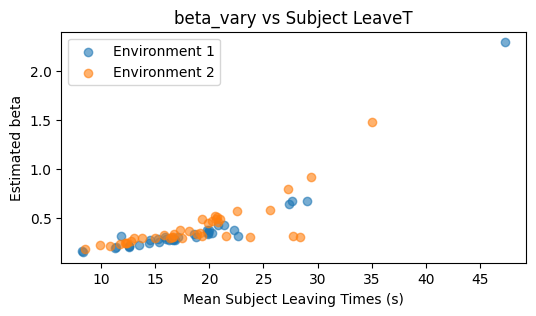

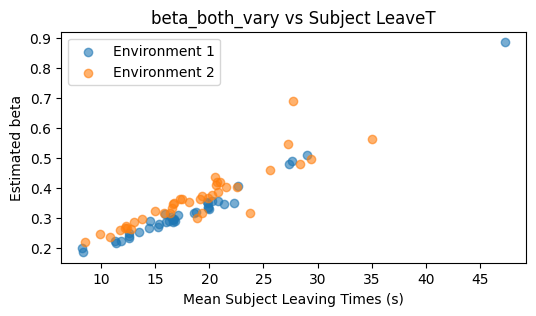

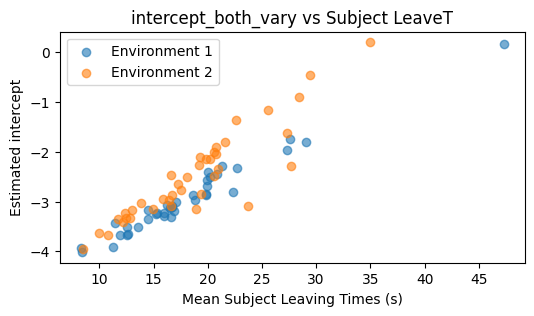

In [216]:
plot_param_vs_mean_leaveT(results_df, mean_times, "beta_vary")
plot_param_vs_mean_leaveT(results_df, mean_times, "beta_both_vary")
plot_param_vs_mean_leaveT(results_df, mean_times, "intercept_both_vary")

### AIC/BIC calculation for model selection

In [258]:
def calculate_aic_bic(n, rss, k):
    # Calculate log-likelihood
    ll = -n / 2 * (np.log(2 * np.pi * rss / n) + 1)
    
    # Calculate AIC and BIC
    aic = 2 * k - 2 * ll
    bic = k * np.log(n) - 2 * ll
    
    return aic, bic

def calculate_subject_aic_bic(df, pred_col_name, k):
    results = []
    subjects = df['sub'].unique()
    
    for sub in subjects:
        sub_data = df[df['sub'] == sub]
        n = len(sub_data)
        rss = np.sum((sub_data['leaveT'] - sub_data[pred_col_name]) ** 2)
        aic, bic = calculate_aic_bic(n, rss, k)
        results.append({
            'sub': sub,
            'aic': aic,
            'bic': bic
        })
        
    results_df = pd.DataFrame(results)
    return results_df

In [264]:
aic_bic_both = calculate_subject_aic_bic(df_trials, 'pred_both_model', k=2)
aic_bic_beta = calculate_subject_aic_bic(df_trials, 'pred_beta_model', k=1)
aic_bic_c = calculate_subject_aic_bic(df_trials, 'pred_intercept_model', k=1)

# Sum AIC and BIC for each model
total_aic_both = aic_bic_both['aic'].sum()
total_bic_both = aic_bic_both['bic'].sum()
total_aic_beta = aic_bic_beta['aic'].sum()
total_bic_beta = aic_bic_beta['bic'].sum()
total_aic_c = aic_bic_c['aic'].sum()
total_bic_c = aic_bic_c['bic'].sum()

# Print the results
print(f"Total AIC for both parameters model: {total_aic_both}")
print(f"Total BIC for both parameters model: {total_bic_both}")
print(f"Total AIC for beta only model: {total_aic_beta}")
print(f"Total BIC for beta only model: {total_bic_beta}")
print(f"Total AIC for intercept only model: {total_aic_c}")
print(f"Total BIC for intercept only model: {total_bic_c}")

Total AIC for both parameters model: 11948.35099361553
Total BIC for both parameters model: 12098.560311314039
Total AIC for beta only model: 11920.359731702329
Total BIC for beta only model: 11995.464390551582
Total AIC for intercept only model: 12709.782871199968
Total BIC for intercept only model: 12784.887530049224


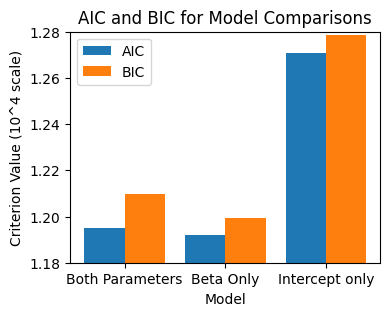

In [265]:
# Plot the AIC and BIC values on a 10^4 scale
labels = ['Both Parameters', 'Beta Only', 'Intercept only']
aic_values = [total_aic_both, total_aic_beta, total_aic_c]
bic_values = [total_bic_both, total_bic_beta, total_bic_c]

x = np.arange(len(labels))

plt.figure(figsize=(4, 3))
plt.bar(x - 0.2, np.array(aic_values) / 10**4, 0.4, label='AIC')
plt.bar(x + 0.2, np.array(bic_values) / 10**4, 0.4, label='BIC')
plt.xlabel('Model')
plt.ylabel('Criterion Value (10^4 scale)')
plt.ylim(1.18, 1.28)
plt.title('AIC and BIC for Model Comparisons')
plt.xticks(x, labels)
plt.legend()
plt.show()

### Variance 

In [266]:
# df_trials['pred_both_model'] = df_trials.apply(calculate_model_leaveT, axis=1, results_df=results_df, beta_col_name = 'beta_both_vary', intercept_col_name = 'intercept_both_vary')
# df_trials['pred_beta_model'] = df_trials.apply(calculate_model_leaveT, axis=1, results_df=results_df, beta_col_name = 'beta_vary', intercept_col_name = 'intercept_constant')
df_compare = df_trials.groupby(['sub', 'env']).agg(
    mean_leaveT=('leaveT', 'mean'),
    mean_model_leaveT_both=('pred_both_model', 'mean'),
    mean_model_leaveT_beta=('pred_beta_model', 'mean'),
    mean_model_leaveT_c=('pred_intercept_model', 'mean'),
    std_leaveT=('leaveT', 'std'),
    std_model_leaveT_both=('pred_both_model', 'std'),
    std_model_leaveT_beta=('pred_beta_model', 'std'),
    std_model_leaveT_c=('pred_intercept_model', 'std'),
).reset_index()
df_compare

,sub,env,mean_leaveT,mean_model_leaveT_both,mean_model_leaveT_beta,mean_model_leaveT_c,std_leaveT,std_model_leaveT_both,std_model_leaveT_beta,std_model_leaveT_c
0,1,1,47.294338,21.055556,43.916667,16.666667,11.478473,4.368929,3.360871,3.612548
1,1,2,34.997398,34.244444,17.222222,15.511111,7.019478,4.539888,3.685378,3.497996
2,2,1,11.283426,15.895238,11.019048,11.180952,3.834020,3.316400,3.175625,2.977413
3,2,2,10.824704,10.019048,9.914286,14.457143,3.066043,3.584592,3.500087,3.013137
4,3,1,16.733743,16.987654,16.419753,17.259259,4.358389,3.518549,2.900917,2.989059
...,...,...,...,...,...,...,...,...,...,...
73,37,2,19.174653,20.416667,21.083333,14.847222,6.333606,4.303970,3.314804,4.294676
74,38,1,16.645795,15.901235,17.024691,17.407407,6.069749,4.272567,3.550522,3.329913
75,38,2,16.648229,15.602564,15.897436,14.512821,5.868071,3.734547,3.287375,3.507745
76,39,1,19.894120,19.260870,19.347826,19.405797,5.904094,3.026744,3.130944,3.992362


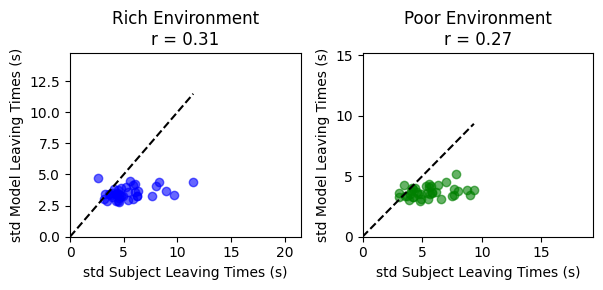

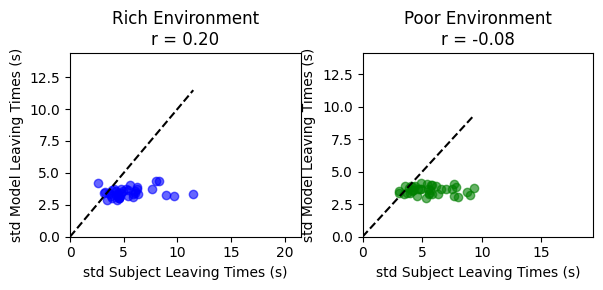

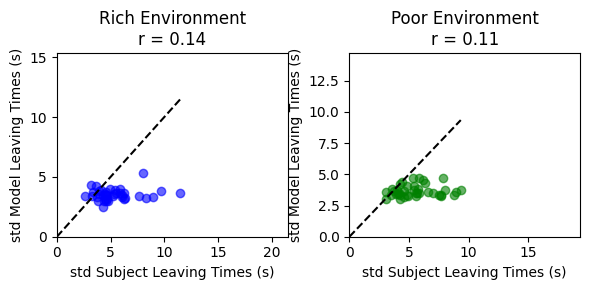

In [267]:
plot_model_fit_comparisons_to_subject_leaving_times(df_compare, "std_leaveT", "std_model_leaveT_both")
plot_model_fit_comparisons_to_subject_leaving_times(df_compare, "std_leaveT", "std_model_leaveT_beta")
plot_model_fit_comparisons_to_subject_leaving_times(df_compare, "std_leaveT", "std_model_leaveT_c")